In [30]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import keras
import numpy as np

from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.13.0-rc1


In [3]:
dataset_dir = os.path.join('/Users/akashmeesa/desktop/aihackathon', 'generated_data')

In [4]:
# dataset_dir='/Users/akashmeesa/desktop/aihackathon/generated_data'


In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['.DS_Store', 'neg', 'pos']

In [6]:
sample_file = os.path.join(train_dir, 'neg/100.txt')
with open(sample_file) as f:
  print(f.read())

15/21/2020         Notice Viewer 

Loan Administration
Deutsche Bank AG, New York

Date: 16/27/2017
TO: GS Funding 2008-1, LTD
ATTN: Agent Notices
Fax: 
Re: CISCO INC(AR 05/12)(MED/CEDG)(C)

***** Rate Setting *****

Description: USD Loan Repricing for the Deal CISCO INC(AR 05/12)(MED/CEDG)(C)

Borrower CISCO INC in Facility 2013 TERM LOAN has the following loans
					Current Reprice
Description		Global Amount	Your Share	Date
--------------------------------------------------------------
Libor Option     1150669342.62     637136.96     03/57/2017



Borrower CISCO INC in Facility 2013 TERM LOAN will make the following interest payments:

Description		Global Amount	Your Share
--------------------------------------------------------------
Libor Option     5778665.11     3199.7


Borrower CISCO INC in Facility 2013 TERM LOAN will have the following new loans:
			Next Reprice
Pricing Option		Global Amount	Your Share	Date
-------------------------------------------------------------- 
Libor

In [7]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'generated_data/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 40000 files belonging to 2 classes.
Using 32000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'12/41/2020         Notice Viewer \n\nLoan Administration\nDeutsche Bank AG, New York\n\nDate: 20/27/2019\nTO: BOA Funding 2001-1, LTD.\nATTN: Agent Notices\nFax: \nRe: RED BULL INC(MJ 09/05)(IDS/WDES)(C)\n\n***** Rate Setting *****\n\nDescription: USD Loan Repricing for the Deal RED BULL INC(MJ 09/05)(IDS/WDES)(C)\n\nBorrower RED BULL INC in Facility 2011 TERM LOAN has the following loans\n\t\t\t\t\tCurrent Reprice\nDescription\t\tGlobal Amount\tYour Share\tDate\n--------------------------------------------------------------\nLibor Option     2596069723.44     1437469.39     07/27/20194\n\n\n\nBorrower RED BULL INC in Facility 2011 TERM LOAN will make the following interest payments:\n\nDescription\t\tGlobal Amount\tYour Share\n--------------------------------------------------------------\nLibor Option     1788242.68     990.17\n\n\nBorrower RED BULL INC in Facility 2011 TERM LOAN will have the following new loans:\n\t\t\tNext Reprice\nPricing Option\t\tGlobal Amount\tYour Sh

In [9]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'generated_data/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 40000 files belonging to 2 classes.
Using 8000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'generated_data/test', 
    batch_size=batch_size)

## have to generate test good and bad data




Found 40000 files belonging to 2 classes.


In [12]:
##this line might break everything
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'03/13/201         Notice Viewer \n\nLoan Administration\nDeutsche Bank AG, New York\n\nDate: 16/30/2017\nTO: BOA Funding 2001-1, LTD.\nATTN: Agent Notices\nFax: \nRe: KRISPY KREME*(MJ 09/05)(DED/JEDM)(C)\n\n***** Rate Setting *****\n\nDescription: USD Loan Repricing for the Deal KRISPY KREME*(MJ 09/05)(DED/JEDM)(C)\n\nBorrower KRISPY KREME INC in Facility 2007 TERM LOAN has the following loans\n\t\t\t\t\tCurrent Reprice\nDescription\t\tGlobal Amount\tYour Share\tDate\n--------------------------------------------------------------\nLibor Option     5217630592.93     2889053.48     03/30/20174\n\n\n\nBorrower KRISPY KREME INC in Facility 2007 TERM LOAN will make the following interest payments:\n\nDescription\t\tGlobal Amount\tYour Share\n--------------------------------------------------------------\nLibor Option     2764644.56     1530.81\n\n\nBorrower KRISPY KREME INC in Facility 2007 TERM LOAN will have the following new loans:\n\t\t\tNext Reprice\nPricing Option\t

In [17]:
##not sure what this does, but will keep for now
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  05222021
 313 --->  12292019
Vocabulary size: 10000


In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
embedding_dim = 16

In [21]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160033 (625.13 KB)
Trainable params: 160033 (625.13 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [22]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [23]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6898 - binary_accuracy: 0.5691 - val_loss: 0.6823 - val_binary_accuracy: 0.8964
Epoch 2/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6631 - binary_accuracy: 0.7854 - val_loss: 0.6373 - val_binary_accuracy: 0.9743
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/step - loss: 0.5971 - binary_accuracy: 0.9543 - val_loss: 0.5551 - val_binary_accuracy: 0.9996
Epoch 4/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5015 - binary_accuracy: 0.9973 - val_loss: 0.4543 - val_binary_accuracy: 0.9999
Epoch 5/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3984 - binary_accuracy: 0.9999 - val_loss: 0.3546 - val_binary_accuracy: 0.9999
Epoch 6/10
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3037 - binary_accuracy: 1.0000 - val_loss: 0.2664 - val_binary_accuracy: 1.0000
Epoch 7/10
1000/1000 [==============================

In [24]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

1250/1250 [==============================] - 7s 6ms/step - loss: 0.0692 - binary_accuracy: 1.0000
Loss:  0.06915145367383957
Accuracy:  0.9999750256538391


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

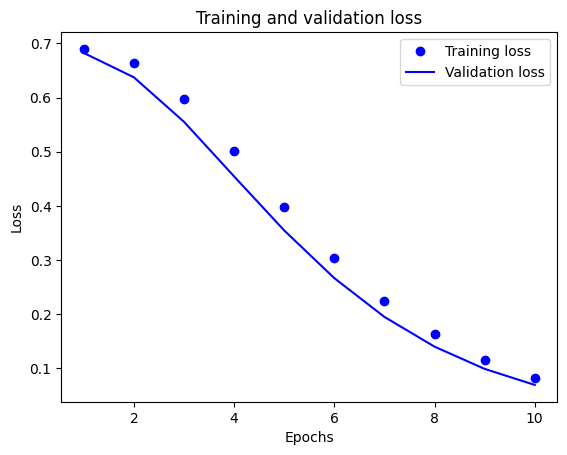

In [26]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

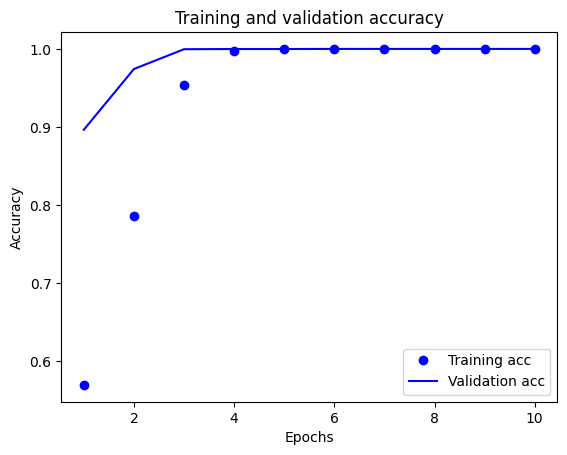

In [27]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)



# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

1250/1250 [==============================] - 7s 5ms/step - loss: 0.0692 - accuracy: 1.0000
0.9999750256538391


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'test_input' is not defined

In [33]:
# examples=[]
# filename='/Users/akashmeesa/desktop/aihackathon/Hackthon_sampleData.txt'
# with open(filename) as f: 
#     examples.append(custom_standardization(f.read()))
# #     export_model.predict(f.read())
 

# convert files to string to be compared to model.

def convert_to_string(route):
    examples=[]
    route ='/Users/akashmeesa/desktop/aihackathon/generated_data/example'

    for filename in os.scandir(route):
        if filename.is_file(): 
            with open(filename, 'r') as file:
#                 data = file.read().replace('\n', '').replace('    ','')
                data=file.read()
                examples.append(data)

    #             print(data)
    #         print(filename.path)
    return examples

examples = convert_to_string('route')

export_model.predict(examples)

1/1 [==============================] - 0s 158ms/step


array([[0.05961154],
       [0.0773242 ],
       [0.9583534 ],
       [0.95957386]], dtype=float32)

In [40]:
# export_model.save('/Users/akashmeesa/desktop/aihackathon/my_model')
# loadedModel = load_model('/Users/akashmeesa/desktop/aihackathon/my_model')
# # model.save('/Users/akashmeesa/desktop/aihackathon/new_model.keras')

# # reconstructed_model = keras.models.load_model('/Users/akashmeesa/desktop/aihackathon/new_model.keras')

# # Let's check:
# np.testing.assert_allclose(
#     model.predict(examples), reconstructed_model.predict(examples)
# )

INFO:tensorflow:Assets written to: /Users/akashmeesa/desktop/aihackathon/my_model/assets


INFO:tensorflow:Assets written to: /Users/akashmeesa/desktop/aihackathon/my_model/assets


AttributeError: 'NoneType' object has no attribute 'get'

In [ ]:
#Things i have to change:
# i need to create a specific way the data is standardized between building the model and the examples I run in it
# preprocessing of data** important step
#try to get model analysis size up by increasing size of data for both training and test sets, ramp up to at least 25k for each


In [41]:
# def convert_to_string_v2(route):
    
#     route ='/Users/akashmeesa/desktop/aihackathon/generated_data/example'
#     counter=0
#     for filename in os.scandir(route):
#         if filename.is_file(): 
#             with open(filename, 'r') as file:
#                 print(counter)
#                 examples=[]
# #                 data = file.read().replace('\n', '').replace('    ','')
#                 data=file.read()
#                 examples.append(data)
#                 counter+=1
        
#         array=export_model.predict(examples)
#         print(array)
#         if float(array[0][0])>=0.5:
#             print(str(filename)+"this is a good file")
#         else:
#             print(str(filename)+"this is a bad file")
        
#     #             print(data)
#     #         print(filename.path)
#     return 0

# # examples = convert_to_string_v2('route')
# convert_to_string_v2('route')
# # export_model.predict(examples)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/aiavengers_hackathon/generated_data/sorted_files.txt'

In [44]:
def convert_to_string_v2(route):
    newdatafile= open('/Users/akashmeesa/desktop/aihackathon/generated_data/sorted_files.txt', 'w')
    route ='/Users/akashmeesa/desktop/aihackathon/generated_data/example'
    counter=0
    for filename in os.scandir(route):
        if filename.is_file(): 
            with open(filename, 'r') as file:
                print(counter)
                examples=[]
#                 data = file.read().replace('\n', '').replace('    ','')
                data=file.read()
                examples.append(data)
                counter+=1
        
        array=export_model.predict(examples)
        print(array)
        if float(array[0][0])>=0.5:
            print(str(filename)[11:-2]+": Good File")
            newdatafile.write(str(filename)[11:-2]+':Good\n')
        else:
            print(str(filename)[11:-2]+": Bad File")
            newdatafile.write(str(filename)[11:-2]+':Bad\n')
        
        
    #             print(data)
    #         print(filename.path)
    newdatafile.close()
    return 0

# examples = convert_to_string_v2('route')
convert_to_string_v2('route')
# export_model.predict(examples)

0
1/1 [==============================] - 0s 69ms/step
[[0.04403804]]
12.txt: Bad File
1
1/1 [==============================] - 0s 17ms/step
[[0.05961153]]
75.txt: Bad File
2
1/1 [==============================] - 0s 18ms/step
[[0.07732418]]
67.txt: Bad File
3
1/1 [==============================] - 0s 14ms/step
[[0.9583534]]
hackathon_84.txt: Good File
4
1/1 [==============================] - 0s 13ms/step
[[0.95957386]]
hackathon_83.txt: Good File


0